Reference - this code is just modification of https://github.com/dennybritz/reinforcement-learning

In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

In [2]:
import gym
import itertools
import matplotlib
import sys
import tensorflow as tf
import collections

matplotlib.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from collections import namedtuple
from matplotlib import pyplot as plt

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode reward over time
    fig = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)

    return fig

# Load Data

In [4]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataFeatures\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)
usdtBtc = usdtBtc

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain['close'], usdtBtcTrain)
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest['close'], usdtBtcTest)
wallet = {'usdt': 1000}
contractPair = ContractPair.new('usdt', 'btc')

In [5]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)

# Dummy Estimators

Just to test learning performance

In [6]:
class DummyPolicyEstimator:
    def predict(self, state):
        return [0.7, 0.1, 0.2] 
    
    def update(self, state, target, action):
        pass

    
class DummyValueEstimator:
    def predict(self, state):
        return 0
    
    def update(self, state, target):
        pass

# Keras perceptron

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation

class KPerceptronPolicyEstimator:
    def __init__(self, numOfFeatures, numOfOutputs, learningRate=0.01):
        self.learningRate = learningRate        
        self.model = Sequential()
        self.model.add(Dense(1, input_dim=numOffeatures))
        self.model.add(Activation('relu'))
        self.model.add(Dense(numOfOutputs))

        
    def predict(self, state):
        return [0.7, 0.1, 0.2] 
    
    def update(self, state, target, action):
        pass

# Reinforce

In [7]:
usdtBtcTrain.columns

Index(['date', 'close', 'return', 'return_1', 'return_2', 'zscore_36_return',
       'zscore_288_return', 'pma36', 'ma_12_108', 'ma_36_288', 'ac36', 'ac288',
       'zscore_36_volume', 'zscore_288_volume', 'zscore_2016_volume', 'vol36',
       'vol288', 'vol2016', 'dv_36_288'],
      dtype='object')

In [8]:
from modeling.rl.enviroment import ExchangeEnv
from modeling.rl.estimator import PerceptronPolicyEstimator, PerceptronValueEstimator

# cols = ['close', 'return', 'return_1', 'return_2', 'zscore_36_return', 'zscore_288_return']

env = ExchangeEnv(
    data=usdtBtcTrain.drop('date', axis=1),
    price_col='close',
    pair=contractPair,
    wallet=wallet,
    fee=0.0025,
    epoch_len=288,
    trade_amount=100
)

In [9]:
from modeling.rl.reinforce import reinforce

tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PerceptronPolicyEstimator(env.observation_space.n, env.action_space.n)
value_estimator = PerceptronValueEstimator(env.observation_space.n)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    stats, episodes = reinforce(env, policy_estimator, value_estimator, 100, discount_factor=1.0)

AttributeError: module 'pandas.core.computation' has no attribute 'expressions'

In [10]:
episode_stats = pd.DataFrame(episodes[-1])
for k in episode_stats['debug'].values[0].keys():
    episode_stats[k] = episode_stats['debug'].apply(lambda x: x[k])

In [11]:
episode_stats

,state,action,reward,next_state,done,debug,initial_value,current_value,err
0,"[[0.0021695185671164463, 0.0029519185931228265...",0,0.0000,"[[-0.0006987545023201536, 0.002169518567116446...",False,"{'initial_value': 1000.0, 'current_value': 100...","1,000.0000","1,000.0000",False
1,"[[-0.0006987545023201536, 0.002169518567116446...",2,0.0000,"[[-0.0017416868611545011, -0.00069875450232015...",False,"{'initial_value': 1000.0, 'current_value': 100...","1,000.0000","1,000.0000",False
2,"[[-0.0017416868611545011, -0.00069875450232015...",2,0.0000,"[[0.001679697096984789, -0.0017416868611545011...",False,"{'initial_value': 1000.0, 'current_value': 100...","1,000.0000","1,000.0000",False
3,"[[0.001679697096984789, -0.0017416868611545011...",0,0.0000,"[[6.357125277611786e-05, 0.001679697096984789,...",False,"{'initial_value': 1000.0, 'current_value': 100...","1,000.0000","1,000.0000",False
4,"[[6.357125277611786e-05, 0.001679697096984789,...",2,0.0000,"[[-0.0014343106991925314, 6.357125277611786e-0...",False,"{'initial_value': 1000.0, 'current_value': 100...","1,000.0000","1,000.0000",False
5,"[[-0.0014343106991925314, 6.357125277611786e-0...",2,0.0000,"[[0.00045207864396257236, -0.00143431069919253...",False,"{'initial_value': 1000.0, 'current_value': 100...","1,000.0000","1,000.0000",False
6,"[[0.00045207864396257236, -0.00143431069919253...",2,0.0000,"[[-0.0036468472991640906, 0.000452078643962572...",False,"{'initial_value': 1000.0, 'current_value': 100...","1,000.0000","1,000.0000",False
7,"[[-0.0036468472991640906, 0.000452078643962572...",2,0.0000,"[[0.0016721483127972725, -0.003646847299164090...",False,"{'initial_value': 1000.0, 'current_value': 100...","1,000.0000","1,000.0000",False
8,"[[0.0016721483127972725, -0.003646847299164090...",2,0.0000,"[[0.0014856387847919095, 0.0016721483127972725...",False,"{'initial_value': 1000.0, 'current_value': 100...","1,000.0000","1,000.0000",False
9,"[[0.0014856387847919095, 0.0016721483127972725...",0,0.0000,"[[-0.001027033419961798, 0.0014856387847919095...",False,"{'initial_value': 1000.0, 'current_value': 100...","1,000.0000","1,000.0000",False


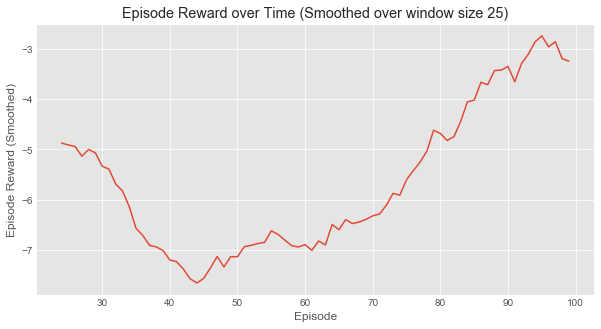

In [12]:
plot_episode_stats(stats, smoothing_window=25);